In [1]:
import os
import pandas as pd
from estnltk import Text
from estnltk import download, get_resource_paths
from estnltk_neural.taggers import EstBERTNERTagger
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import pickle
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

/home/kaire/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-08-06 10:41:57.948784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 10:41:58.047350: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 10:41:58.049889: W tensorflow/compiler/xla/stream_executor/platform/defau

In [2]:
# Initialize tagger with the model
model_location = get_resource_paths("estbertner_v2", only_latest=True)
neural_ner2 = EstBERTNERTagger(model_location=model_location, output_layer='estbertner2')

In [3]:
with open("elusolendid.srt", "r") as f:
    faildata = f.readlines()

faildata = [row.strip() for row in faildata]
elusolendid = [elem.split(" ",1)[1].strip() for elem in faildata]

In [21]:
data = pd.read_csv("obl_1000_benchmark.csv", sep=";", encoding="utf-8")
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel oue 57 % paki hinnast .",NaN,NaN,NaN,no,"Tõusevad praktilis

In [5]:
def get_ner_timexes(sentence, phrase, elus):
    text = Text(sentence)
    text = text.tag_layer('morph_analysis')
    
    phrase_is_ner = False
    phrase_is_timex = False
    
    phrase_lemmas = list(set(chain.from_iterable(list(text["morph_analysis"].lemma))))    
    phrase_is_elus = False
    
    if phrase in elus:
        phrase_is_elus = True

    for lem in phrase_lemmas:
        if lem in elus:
            phrase_is_elus = True
    
    
    try:
        neural_ner2.tag(text)
    except Exception as e:
        return None, None, phrase_is_ner, phrase_is_timex, phrase_is_elus
    text.tag_layer('timexes')
    
    timexes = set(text["timexes"].text)
    ners = set([named_entity.enclosing_text for named_entity in text["estbertner2"] if named_entity.nertag in ["LOC", "GPE", "DATE", "TIME", "EVENT"]])
    
    if phrase in timexes or any(phrase in t for t in timexes):
        phrase_is_timex = True
    if phrase in ners or any(phrase in n for n in ners):
        phrase_is_ner = True
        
    
    return ners, timexes, phrase_is_ner, phrase_is_timex, phrase_is_elus

In [6]:
ner_data = []
timex_data = []
is_ner_data = []
is_timex_data = []
is_elus_data = []

for i in tqdm(range(len(data))):
    sent = data.iloc[i]["sentence"]
    phrase = data.iloc[i]["removed"]    
    
    ner, timex, is_ner, is_timex, is_elus = get_ner_timexes(sent, phrase, elusolendid)
    
    ner_data.append(ner)
    timex_data.append(timex)
    is_ner_data.append(is_ner)
    is_timex_data.append(is_timex)
    is_elus_data.append(is_elus)

100%|███████████████████████████████████████| 1000/1000 [01:09<00:00, 14.44it/s]


In [23]:
data["found_ners"] = ner_data
data["found_timexes"] = timex_data
data["phrase_is_ner"] = is_ner_data
data["phrase_is_timex"] = is_timex_data
data["phrase_is_elus"] = is_elus_data
data["can_be_removed"] = "yes"
data["remove_label"] = 1

In [24]:
data.loc[data.phrase_is_elus == True, 'can_be_removed'] = "no"
data.loc[data.phrase_is_elus == True, 'remove_label'] = 0

data.loc[data.phrase_is_ner == True, 'can_be_removed'] = "yes"
data.loc[data.phrase_is_timex == True, 'can_be_removed'] = "yes"
data.loc[data.phrase_is_ner == True, 'remove_label'] = 1
data.loc[data.phrase_is_timex == True, 'remove_label'] = 1

In [19]:
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,...,peasona,verb,label,found_ners,found_timexes,phrase_is_ner,phrase_is_timex,phrase_is_elus,can_be_removed,remove_label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,...,peale,osaleda,1,{},{},False,False,True,no,0
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,...,elamispinda,investeerida,1,{},{},False,False,True,no,0
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,...,Marsile,anti,1,{},{},False,False,True,no,0
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,...,haiglas,saada,1,{},{},False,False,True,no,0
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,...,aeda,kargas,1,{},{},False,False,True,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,...,kohast,loobib,0,{},{},False,False,True,no,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,...,aastal,kommenteerima,0,{},{aastal 1985 .},False,True,True,no,0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel oue 57 % paki hinnast .",NaN,NaN,...,sigarettidel,Tõusevad,0,{},{},False,False,True,no,0
998,636,Train/aja_ee200110_osa_8_ud211.conllu,""" Iga koosolek hakkas jälle sõjaga peale , et midagi sellist ei tehtaks , "" meenutab Rannamäe .",46,52,midagi,bound,""" Iga koosolek hakkas jälle sõjaga peale , et sellist ei tehtaks , "" meenutab Rannamäe .",100.0,100.0,...,midagi,tehtaks,0,{},{},False,False,True,no,0


In [25]:
predicted = list(data['remove_label'])
y_test = list(data['label'])

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision.round(3)))
print('recall: {}'.format(recall.round(3)))
print('fscore: {}'.format(fscore.round(3)))
print('support: {}'.format(support.round(3)))

try:
    precision = precision_score(y_test, predicted, pos_label=1, average='binary')
    recall = recall_score(y_test, predicted, pos_label=1, average='binary')
except:
    precision = precision_score(y_test, predicted, labels=[1], average='micro')
    recall = recall_score(y_test, predicted, labels=[1], average='micro')
print('precision: ',precision.round(3))
print('recall: ',recall.round(3))

precision: [0.511 0.569]
recall: [0.882 0.156]
fscore: [0.647 0.245]
support: [500 500]
precision:  0.569
recall:  0.156


In [26]:
data["match"] = data.remove_label.eq(data.label) # true if annotation and prediction are the same

In [27]:
data.value_counts("match")

match
True     519
False    481
Name: count, dtype: int64

In [28]:
data.value_counts("remove_label")

remove_label
0    863
1    137
Name: count, dtype: int64

In [29]:
# Compute global precision and recall
precision1, recall1, thresh1 = precision_recall_curve(y_test, predicted, pos_label=1)

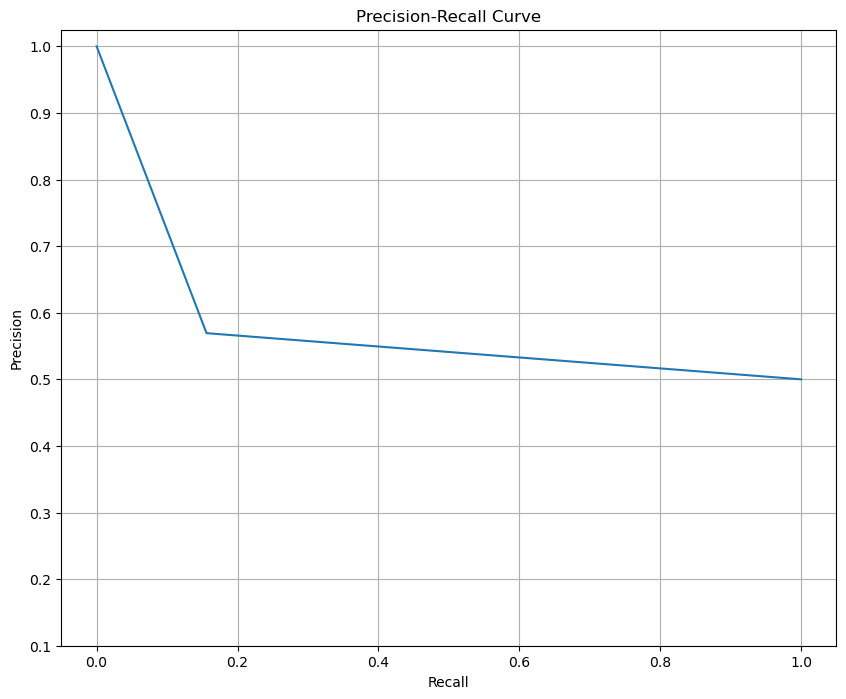

In [30]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)

In [32]:
roc_auc = auc(fpr, tpr)

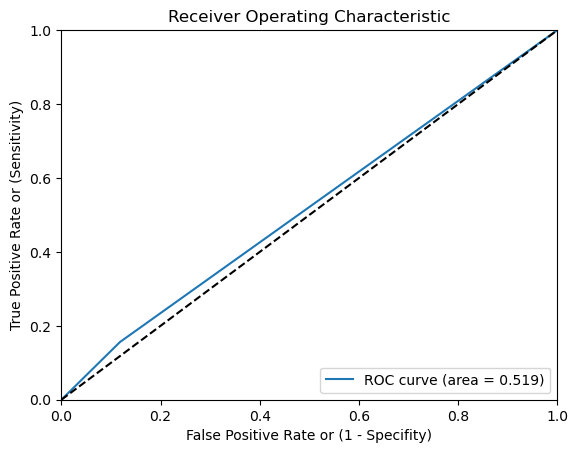

In [33]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [34]:
#data.to_csv("obl_gpt_large1_ner_timex_estbertner2_elusolend_benchmark.csv", index=False, sep=";", encoding="utf-8")